In [1]:
import pandas as pd
from bitarray import frozenbitarray

In [2]:
import numpy as np
!pip install git+https://github.com/EgorDudyrev/paspailleur.git

  Cloning https://github.com/EgorDudyrev/paspailleur.git to /private/var/folders/28/jmw8nj2d5p9crv64k2tq98400000gn/T/pip-req-build-jrwjkbwy
  Running command git clone --filter=blob:none --quiet https://github.com/EgorDudyrev/paspailleur.git /private/var/folders/28/jmw8nj2d5p9crv64k2tq98400000gn/T/pip-req-build-jrwjkbwy
  Resolved https://github.com/EgorDudyrev/paspailleur.git to commit bad718a7d0396217fc5552a9152d14c5dc99581e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
from importlib import reload

In [4]:
from script import clustering as clib

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/paspailleur/pattern_structures/abstract_ps.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn import datasets

n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
X, y = noisy_circles

In [6]:
from paspailleur import pattern_structures as PS
linscale = np.linspace(-1.5, 1.5, 11)
ps = PS.CartesianPS([PS.IntervalPS(values=linscale), PS.IntervalPS(values=linscale)])

In [7]:
clib = reload(clib)

In [8]:
min_support = 0.05
max_support = 0.8
min_delta_stability = 0.01

In [9]:
data = list(ps.preprocess_data(X))
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_support))
print(len(attributes))

34


In [10]:
import caspailleur as csp

In [11]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_support,
    use_tqdm=True, n_attributes=len(attributes)
)

  0%|          | 0/34 [00:00<?, ?it/s]

CPU times: user 17.8 ms, sys: 7.9 ms, total: 25.7 ms
Wall time: 25.3 ms


In [12]:
%%time
concepts_df = pd.DataFrame(clib.mine_clusters_info(stable_extents, attr_extents, ps, data, min_support, max_support, None, True))
concepts_df.head()

Compute intents:   0%|          | 0/793 [00:00<?, ?it/s]

CPU times: user 859 ms, sys: 21.4 ms, total: 880 ms
Wall time: 880 ms


,extent,intent,delta_stability,support,frequency,intent_human,level
0,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","((-0.9, 0.9, (BoundStatus.RCLOSED, BoundStatus...",35,400,0.800,"x0: [-0.90, 0.90], x1: [-0.90, 1.20]",2
1,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","((-1.2, 0.9, (BoundStatus.RCLOSED, BoundStatus...",35,400,0.800,"x0: [-1.20, 0.90], x1: [-0.90, 0.90]",2
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-0.9, 1.2, (BoundStatus.RCLOSED, BoundStatus...",34,399,0.798,"x0: [-0.90, 1.20], x1: [-0.90, 0.90]",2
3,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-1.2, 1.2, (BoundStatus.RCLOSED, BoundStatus...",34,397,0.794,"x0: [-1.20, 1.20], x1: [-0.90, 0.60]",1
4,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...","((-0.9, 0.9, (BoundStatus.RCLOSED, BoundStatus...",31,396,0.792,"x0: [-0.90, 0.90], x1: [-1.20, 0.90]",2


In [13]:
clib = reload(clib)

import seaborn as sns
sns.distplot(concepts_df['delta_stability'])

In [14]:
clib.clustering_reward2(
    [0, 757, 760, 774], concepts_df,
    overlap_weight=0.1,
    n_concepts_weight=0.05,
    balance_weight=0.1,
    stability_weight=0.05,
    complexity_weight=0.05,
    n_concepts_max = 5
)

(0.8406150715324301,
 {'coverage': 0.906,
  'overlap': 0.014666666666666666,
  'n_concepts': 0.8,
  'balance': 0.18406738199096626,
  'stability': 0.0285,
  'complexity': 0.875})

In [15]:
clib.clustering_reward2(
    [0], concepts_df,
    overlap_weight=0.1,
    n_concepts_weight=0.05,
    balance_weight=0.1,
    stability_weight=0.05,
    complexity_weight=0.05,
    n_concepts_max = 5
)

(0.7565234347048118,
 {'coverage': 0.8,
  'overlap': 0,
  'n_concepts': 0.2,
  'balance': 0.1302343470481181,
  'stability': 0.07,
  'complexity': 1.0})

In [16]:
clib = reload(clib)

In [17]:
%%time
best_clustering_old, best_log_old = clib.clusterise_v0(
    concepts_df, overlap_weight=0.5, n_concepts_weight=0.01
)
print(best_clustering_old)

[0, 757, 759, 776]
CPU times: user 77.4 ms, sys: 1.83 ms, total: 79.3 ms
Wall time: 78.5 ms


In [18]:
%%time
reward_weights = dict(
    overlap_weight=0.5, n_concepts_weight=0.0, balance_weight=0.1,
    stability_weight=0.1, complexity_weight=0.2,

)
best_clustering, best_log, top_log = clib.clusterise_v1(
    concepts_df, thrift_factor=2, n_clusters_min=2, n_clusters_max=10,
    **reward_weights
    #**{k: reward_weights[k] for k in ['overlap_weight', 'n_concepts_weight', 'complexity_weight']}
)
print(best_clustering)

[9, 580, 759]
CPU times: user 32.8 s, sys: 723 ms, total: 33.5 s
Wall time: 33.5 s


In [19]:
from script import visual_lib as vlib
import matplotlib.pyplot as plt

In [20]:
vlib = reload(vlib)

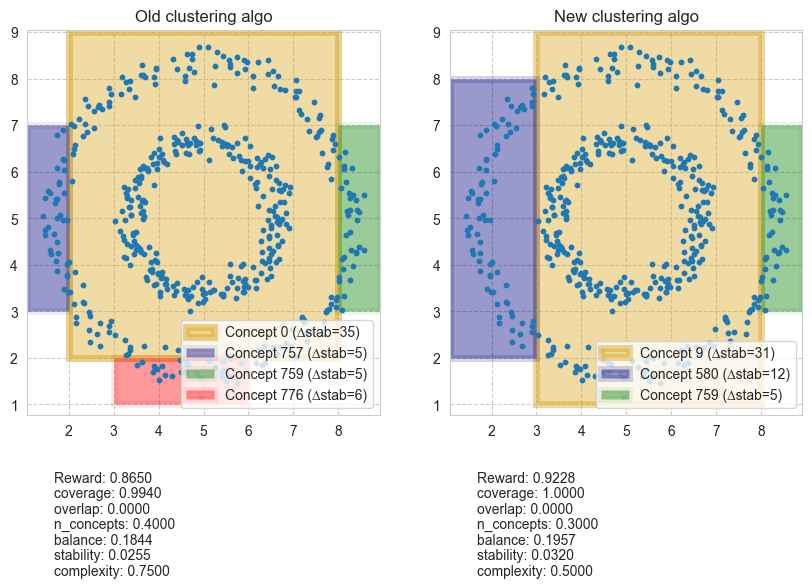

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
vlib.init_axis(ax, f"Old clustering algo", linscale, linscale, range(len(linscale)), range(len(linscale)), grid_params=dict(zorder=0, linestyle='--'))

reward, reward_details = clib.clustering_reward2(best_clustering_old, concepts_df, **reward_weights)
for i, (k, v) in enumerate([('Reward', reward)]+ list(reward_details.items())):
    ax.text(-1, -1.7-i*0.1, f"{k}: {v:.4f}")

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(ax, best_clustering_old, concepts_df)
ax.legend(loc='lower right')


ax = axs[1]
vlib.init_axis(ax, f"New clustering algo", linscale, linscale, range(len(linscale)), range(len(linscale)), grid_params=dict(zorder=0, linestyle='--'))

ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
vlib.draw_clustering(ax, best_clustering, concepts_df)

reward, reward_details = clib.clustering_reward2(best_clustering, concepts_df, **reward_weights)
for i, (k, v) in enumerate([('Reward', reward)]+ list(reward_details.items())):
    ax.text(-1, -1.7-i*0.1, f"{k}: {v:.4f}")


ax.legend(loc='lower right')
#fig.savefig('../figures/pipe_step4_circlesdata.pdf')
plt.show()

In [22]:
concepts_df.loc[best_clustering_old][['intent', 'level']]

,intent,level
0,"((-0.9, 0.9, (BoundStatus.RCLOSED, BoundStatus...",2
757,"((-1.2, -0.9, (BoundStatus.RCLOSED, BoundStatu...",1
759,"((0.9, 1.2, (BoundStatus.RCLOSED, BoundStatus....",1
776,"((-0.6, 0.3, (BoundStatus.RCLOSED, BoundStatus...",2


In [23]:
concepts_df.loc[best_clustering][['intent', 'level']]

,intent,level
9,"((-0.6, 0.9, (BoundStatus.RCLOSED, BoundStatus...",1
580,"((-1.2, -0.6, (BoundStatus.RCLOSED, BoundStatu...",1
759,"((0.9, 1.2, (BoundStatus.RCLOSED, BoundStatus....",1
